In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
# 1.a Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())

testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

training_data.data.shape, testing_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [3]:
# 1.b DataLoader
from torch.utils.data import DataLoader

training_dataloader = DataLoader(training_data, 64, shuffle=True)
testing_dataloader = DataLoader(testing_data, 64, shuffle=False)

X, y = next(iter(training_dataloader))
X.shape, y.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

In [4]:
cuda_X, cuda_y = X.to(device), y.to(device)

In [5]:
# play with conv layer
from torch import nn

# build a conv layer with basic parameter
# n input channel, n output feature, ks:kenel size, act:activate
def conv(ni, nf, ks=3, stride=1, act=True):
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    res = nn.Sequential(*layers)
    return res

def block(ni, nf): return conv(ni, nf)

# get model from block
def get_model():
    return nn.Sequential(
            block(1,16),   #14x14
            block(16,32),  #7x7
            block(32, 64), #4x4
            block(64, 128),#2x2
            block(128,256),#1x1
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 10)).to(device)

model = get_model()
print(X.shape, model(X.to(device)).shape)

torch.Size([64, 1, 28, 28]) torch.Size([64, 10])


In [6]:
y_hat = model(X.to(device))

In [7]:
# 3. Loss
loss_fn = nn.CrossEntropyLoss()

loss = loss_fn(y_hat, y.to(device))

loss.backward()

In [8]:
# 4. Optimizer SGD
from torch.optim import SGD

In [20]:
# Learning rate finder:
import matplotlib.pyplot as plt

def learning_rate_finder(model, dataloader, cut_off=3):
    lr = 1e-6
    lrs = []
    losses = []
    optimizer = SGD(model.parameters(), lr=lr)

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        # update lr
        optimizer.param_groups[0]['lr'] *= 1.1
        if optimizer.param_groups[0]['lr'] > 1: break
    plt.xscale('log')
    plt.plot(lrs[0:-cut_off], losses[0:-cut_off])
    plt.show()

In [21]:
model = get_model().to(device)

145


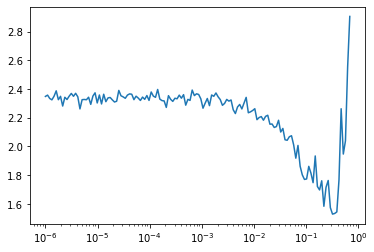

In [22]:
learning_rate_finder(model, training_dataloader)

In [13]:
# 5. Combine things together:
# train model
def train(model, dataloader, optimizer, epochs=2):
    size = len(dataloader.dataset)
    for epoch in range(epochs):
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # backward
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 300 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

# learning_rate_finder(model, training_dataloader)
optimizer = SGD(model.parameters(), lr=1e-2)
train(model, training_dataloader, optimizer)

loss: 6.322217  [    0/60000]
loss: 1.490482  [19200/60000]
loss: 1.155929  [38400/60000]
loss: 0.969711  [57600/60000]
loss: 0.963188  [    0/60000]
loss: 0.688603  [19200/60000]
loss: 0.746929  [38400/60000]
loss: 0.846988  [57600/60000]


In [14]:
def test(model, testing_dataloader):
    size = len(testing_dataloader.dataset)
    total = 0
    for X, y in testing_dataloader:
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        total += sum(y_hat.argmax(1) == y).item()
    print(f'Accuracy: {total/size:>2f}')
    
test(model, testing_dataloader)

Accuracy: 0.740700


In [15]:
# Base-line models:
model = get_model()
optimizer = SGD(model.parameters(), lr=1e-2)
train(model, training_dataloader, optimizer, 10)
test(model, testing_dataloader)
# 0.887400

loss: 2.307364  [    0/60000]
loss: 1.250921  [19200/60000]
loss: 1.038132  [38400/60000]
loss: 0.951336  [57600/60000]
loss: 0.951028  [    0/60000]
loss: 0.804053  [19200/60000]
loss: 0.642646  [38400/60000]
loss: 0.778798  [57600/60000]
loss: 0.668624  [    0/60000]
loss: 0.727460  [19200/60000]
loss: 0.512934  [38400/60000]
loss: 0.604623  [57600/60000]
loss: 0.429797  [    0/60000]
loss: 0.400999  [19200/60000]
loss: 0.446318  [38400/60000]
loss: 0.512685  [57600/60000]
loss: 0.562962  [    0/60000]
loss: 0.392147  [19200/60000]
loss: 0.433248  [38400/60000]
loss: 0.498035  [57600/60000]
loss: 0.431864  [    0/60000]
loss: 0.448343  [19200/60000]
loss: 0.420028  [38400/60000]
loss: 0.388215  [57600/60000]
loss: 0.530158  [    0/60000]
loss: 0.522580  [19200/60000]
loss: 0.479356  [38400/60000]
loss: 0.403045  [57600/60000]
loss: 0.306167  [    0/60000]
loss: 0.568193  [19200/60000]
loss: 0.401648  [38400/60000]
loss: 0.347534  [57600/60000]
loss: 0.415871  [    0/60000]
loss: 0.35

In [24]:
from IPython.core.debugger import set_trace

def noop(x):
    return x

# ResnetBlock
class ResnetBlock(nn.Module):
    def __init__(self, ni, nf, stride=2):
        super(ResnetBlock, self).__init__()
        self.convs = nn.Sequential(
                        conv(ni, nf),
                        conv(nf, nf, stride=stride, act=False))
        self.pool = noop if stride == 1 else nn.AvgPool2d(stride, ceil_mode=True)
        self.idconv = noop if ni == nf else conv(ni, nf, ks=1, act=False)
    def forward(self, x):
        return nn.ReLU()(self.convs(x) + self.idconv(self.pool(x)))

In [30]:
# Resnet block
def block(ni, nf): return ResnetBlock(ni, nf)
model = get_model()
# learning_rate_finder(model, training_dataloader) # 1e-3
optimizer = SGD(model.parameters(), lr=1e-3)
train(model, training_dataloader, optimizer, 10)
test(model, testing_dataloader)
# 0.893100

loss: 2.409477  [    0/60000]
loss: 0.809506  [19200/60000]
loss: 0.488903  [38400/60000]
loss: 0.443032  [57600/60000]
loss: 0.361572  [    0/60000]
loss: 0.437329  [19200/60000]
loss: 0.404649  [38400/60000]
loss: 0.398841  [57600/60000]
loss: 0.519046  [    0/60000]
loss: 0.281683  [19200/60000]
loss: 0.342593  [38400/60000]
loss: 0.493653  [57600/60000]
loss: 0.337458  [    0/60000]
loss: 0.395097  [19200/60000]
loss: 0.325945  [38400/60000]
loss: 0.330187  [57600/60000]
loss: 0.285656  [    0/60000]
loss: 0.358407  [19200/60000]
loss: 0.268115  [38400/60000]
loss: 0.427586  [57600/60000]
loss: 0.375046  [    0/60000]
loss: 0.356660  [19200/60000]
loss: 0.359474  [38400/60000]
loss: 0.307111  [57600/60000]
loss: 0.370927  [    0/60000]
loss: 0.354159  [19200/60000]
loss: 0.379436  [38400/60000]
loss: 0.226016  [57600/60000]
loss: 0.220839  [    0/60000]
loss: 0.316794  [19200/60000]
loss: 0.088350  [38400/60000]
loss: 0.167319  [57600/60000]
loss: 0.214590  [    0/60000]
loss: 0.13

In [31]:
# stack block
def block(ni, nf): return nn.Sequential(ResnetBlock(ni, nf), ResnetBlock(nf, nf, stride=1))
model = get_model()
# learning_rate_finder(model, training_dataloader) # 1e-3
optimizer = SGD(model.parameters(), lr=1e-3)
train(model, training_dataloader, optimizer, 10)
test(model, testing_dataloader)
# 0.893100

loss: 2.326237  [    0/60000]
loss: 0.752521  [19200/60000]
loss: 0.475189  [38400/60000]
loss: 0.560834  [57600/60000]
loss: 0.423104  [    0/60000]
loss: 0.659659  [19200/60000]
loss: 0.550457  [38400/60000]
loss: 0.425709  [57600/60000]
loss: 0.387782  [    0/60000]
loss: 0.268971  [19200/60000]
loss: 0.318121  [38400/60000]
loss: 0.335748  [57600/60000]
loss: 0.192609  [    0/60000]
loss: 0.423895  [19200/60000]
loss: 0.377841  [38400/60000]
loss: 0.137894  [57600/60000]
loss: 0.258547  [    0/60000]
loss: 0.187302  [19200/60000]
loss: 0.222946  [38400/60000]
loss: 0.316030  [57600/60000]
loss: 0.204746  [    0/60000]
loss: 0.297774  [19200/60000]
loss: 0.235617  [38400/60000]
loss: 0.170636  [57600/60000]
loss: 0.174542  [    0/60000]
loss: 0.406716  [19200/60000]
loss: 0.166058  [38400/60000]
loss: 0.146371  [57600/60000]
loss: 0.201122  [    0/60000]
loss: 0.238349  [19200/60000]
loss: 0.093672  [38400/60000]
loss: 0.130995  [57600/60000]
loss: 0.070526  [    0/60000]
loss: 0.11